In [1]:
import cv2
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from os.path import join

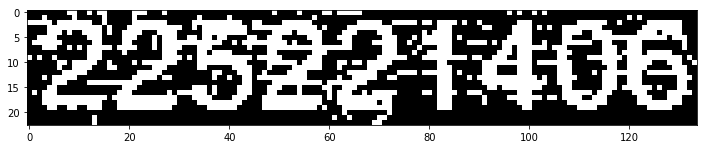

In [11]:
plt.rcParams["figure.figsize"] = [12.0, 8.0]
digit_type_dir = "many_digit_groups"
image_name = "841289701567_0902402840_225221406_1_2015091011245935.jpgcardnumber.png"
image_path = join('only_number_id_test', digit_type_dir, image_name)
in_img = cv2.imread(image_path, 0)
# kernel_size = 2
# kernel = np.ones((kernel_size, kernel_size),np.uint8)
# in_img = cv2.morphologyEx(in_img, cv2.MORPH_OPEN, kernel)
# in_img = cv2.morphologyEx(in_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(in_img, cmap='gray')
plt.show()

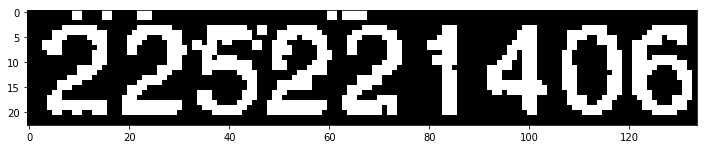

In [7]:
# in_img = opening
_, thresh = cv2.threshold(in_img, 127, 255, 0)
plt.imshow(thresh, cmap='gray')
plt.show()

15


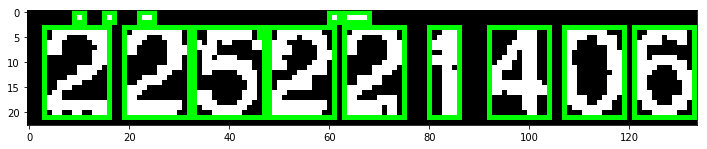

In [8]:
# thresh = opening
img2, contours, hierarchy = cv2.findContours(thresh, mode=cv2.RETR_EXTERNAL, method=2)
# img2, contours, hierarchy = cv2.findContours(thresh, mode=1, method=2)
thresh_coloured = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

num_contours = len(contours)
contour_areas = [0] * num_contours
heights = [0] * num_contours

print(num_contours)
img_height = thresh_coloured.shape[0]

for i in range(0, num_contours):
    x,y,w,h = cv2.boundingRect(contours[i])
    heights[i] = h / img_height
    cv2.rectangle(thresh_coloured, (x, y),(x + w, y + h), (0, 255, 0), 1)
    contour_areas[i] = cv2.contourArea(contours[i])
plt.imshow(thresh_coloured, cmap = 'gray')

94.0


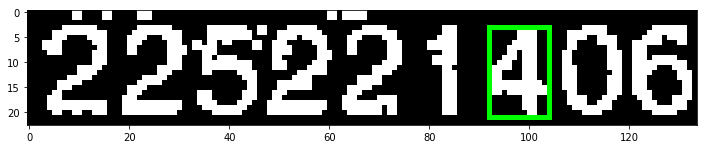

In [9]:
contour_index = 2
print(contour_areas[contour_index])

thresh_coloured = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
x,y,w,h = cv2.boundingRect(contours[contour_index])
cv2.rectangle(thresh_coloured, (x, y),(x + w, y + h), (0, 255, 0), 1)

plt.imshow(thresh_coloured, cmap = 'gray')

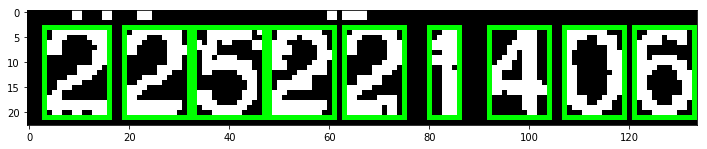

In [10]:
# desc_cnt_idx = np.flipud(np.argsort(np.array(contour_areas)))
desc_cnt_idx = np.flipud(np.argsort(np.array(heights)))

# print(len(desc_cnt_idx))
thresh_coloured = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

num_digits = 9
horizontal_top_lefts = [0] * num_digits
rects = [None] * num_digits
digit_contours = np.array(contours)[desc_cnt_idx[0:num_digits]]
# print(digit_contours.shape)
# print(rects)

for i in range(num_digits):
    x,y,w,h = cv2.boundingRect(digit_contours[i])
    rects[i] = (x, y, w, h)
#     print(rects[i][0])
    horizontal_top_lefts[i] = x
    cv2.rectangle(thresh_coloured, (x, y),(x + w, y + h), (0, 255, 0), 1)
plt.imshow(thresh_coloured, cmap = 'gray')

In [141]:
np_rects = np.array(rects)
digit_order_idx = np.argsort(np.array(horizontal_top_lefts))
print(digit_order_idx)
for i in range(num_digits):
    x = rects[digit_order_idx[i]][0]
    y = rects[digit_order_idx[i]][1]
    w = rects[digit_order_idx[i]][2]
    h = rects[digit_order_idx[i]][3]
    
    cv2.imwrite("digit_"+str(i)+".png", in_img[y:y+h+1,x:x+w+1])

[0 1 2 3 4 5 6 7 8]


In [142]:
def square_padding(ori_img):
    squared_img = ori_img
    height, width = ori_img.shape
    if (width != height):
        BLACK = [0, 0, 0]
        if (width > height):
            diff = width - height
            if (diff % 2 == 0):
                padding = int(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, padding, padding, 0, 0, cv2.BORDER_CONSTANT,value=BLACK)
            else:
                padding = floor(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, padding+1, padding, 0,0, cv2.BORDER_CONSTANT,value=BLACK)
        else:
            diff = height - width
            if (diff % 2 == 0):
                padding = int(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, 0, 0, padding, padding, cv2.BORDER_CONSTANT,value=BLACK)
            else:
                padding = floor(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, 0,0, padding+1, padding, cv2.BORDER_CONSTANT,value=BLACK)
    return squared_img

In [143]:
digit_img = np.array([None] * num_digits)
for i in range(num_digits):
    x = rects[digit_order_idx[i]][0]
    y = rects[digit_order_idx[i]][1]
    w = rects[digit_order_idx[i]][2]
    h = rects[digit_order_idx[i]][3]
    digit_img[i] = square_padding(in_img[y:y+h+1,x:x+w+1])

In [144]:
import caffe

# caffe.set_device(0)
# caffe.set_mode_gpu()
caffe.set_mode_cpu()
_net = caffe.Net('../lenet_deploy.prototxt', '../mixed_lenet_8817_id_digit.caffemodel', caffe.TEST)

In [145]:
def numberSeq2Str(digit_img_arr, net):
    id_str = ''
    
    for digit in digit_img_arr:
        digit = cv2.resize(digit, (28, 28))
#         print(digit.shape)
#         digit = digit.astype(np.dtype(np.float64)) * (1.0 / 255.0)
        digit = digit.astype(np.float64) * (1.0 / 255.0)
        net.blobs['data'].data[...] = digit[np.newaxis, np.newaxis, :, :]
        out = _net.forward()
        id_str += str(out['prob'].argmax())
    return id_str

In [146]:
numberSeq2Str(digit_img, _net)

'225221406'